In [3]:
"""
import tarfile
import os

archive_path = "./data/cifar-10-python.tar.gz"
extract_path = "./data"

# Extract
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=extract_path)


print("Files in data folder after extraction:", os.listdir(extract_path))
"""

'\nimport tarfile\nimport os\n\narchive_path = "./data/cifar-10-python.tar.gz"\nextract_path = "./data"\n\n# Extract\nwith tarfile.open(archive_path, "r:gz") as tar:\n    tar.extractall(path=extract_path)\n\n\nprint("Files in data folder after extraction:", os.listdir(extract_path))\n'

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
subset_size = 5000
validation_size = int(subset_size/5) # får inte va float
train_size = subset_size - validation_size

batch_size = 50

# Normalisera (0, 255) -> (-1, 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Hämta data från ./data
train_val_set_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=False, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root="./data", train=False, download=False, transform=transform)

# tar första subset_size st samples för att använda
train_val_set = torch.utils.data.Subset(train_val_set_full, range(subset_size))
train_subset, val_subset = torch.utils.data.random_split(train_val_set, [train_size, validation_size])

#test_subset = torch.utils.data.Subset(testset_full, range(subset_size))
test_subset = testset_full  # Lika bra att använda alla här när vi använder validering data

# batch uppdeling för cnn
cnn_train = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
cnn_val = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
cnn_test = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False) # tror shuffle bara ska ändra så man har unika batches för olika epoker, ingen use för val och test

# SVM behöver feature vector, tensor 32x32x3 -> 3072 features
def dataset_to_numpy(dataset):
    X = np.array([np.array(img).flatten() for img, _ in dataset]) # data
    y = np.array([label for _, label in dataset]) # labels
    return X, y

X_train, y_train = dataset_to_numpy(train_subset)
X_val, y_val = dataset_to_numpy(val_subset)
X_test, y_test = dataset_to_numpy(test_subset)

# normalisera data för svm
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # ingen data leak i testset

print("Training samples:", X_train.shape[0])
print("Input dimensions (features):", X_train.shape[1])
print("Max svm pixel range after scaling:", (X_train.min(), X_train.max()))

Training samples: 4000
Input dimensions (features): 3072
Max svm pixel range after scaling: (-2.1986444, 2.7264934)


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 3x3 sliding window gör så att vi behöver 1 extra ruta åt alla håll (padding=1)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10) # 3072 -> 10 klasser

    def forward(self, x):
        x = F.relu(self.conv1(x)) # (N, 16, 32, 32)
        x = self.pool(F.relu(self.conv2(x))) # 32x32 -> 16x16  (N, 32, 16, 16)
        x = self.pool(x) # 16x16 -> 8x8  (N, 32, 8, 8)
        x = x.view(batch_size, 32 * 8 * 8)  # (N, 32, 8, 8) -> (N, 2048) Härifrån vanligt NN
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(batch_size, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class WideCNN(nn.Module):
    def __init__(self):
        super(WideCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(batch_size, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


In [7]:
def validation_pca_svm(X_train, y_train, X_val, y_val, pca_components=100, C=1, gamma='scale'):
    pca = PCA(n_components=pca_components)

    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    svm_pca = SVC(kernel='rbf', C=C, gamma=gamma) # keep rbf
    svm_pca.fit(X_train_pca, y_train)

    y_pred_pca = svm_pca.predict(X_val_pca)
    svm_acc_pca = accuracy_score(y_val, y_pred_pca) * 100

    return svm_acc_pca

def validation_cnn_setup(model_variant=SimpleCNN, cnn_train=cnn_train, cnn_val=cnn_val, lr=0.001, max_epochs=50, val_interval=4):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_variant().to(device)
    criterion = nn.CrossEntropyLoss() # logsoftmax + NLLLoss
    optimizer = optim.Adam(model.parameters(), lr=lr) # adam borde vara mycket snabbare än sgd

    print("Training CNN")
    best_val_acc = 0
    final_val_acc = 0
    best_epoch = 0

    start_time = time.time()
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in cnn_train:

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        normalized_running_loss = running_loss / len(cnn_train)
        print("Running loss for epoch", epoch+1, ":", round(normalized_running_loss, 3))

    
        if (epoch + 1) % val_interval == 0 or epoch == max_epochs-1:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in cnn_val:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100 * correct/total
            print("Validation check after epoch", epoch + 1, "- accuracy:", round(val_acc, 3), "%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                final_val_acc = val_acc
                best_epoch = epoch + 1
            else:
                final_val_acc = val_acc
                print("Stopping early at epoch", epoch+1)
                break

    end_time = time.time()
    print("CNN validation accuracy after ", epoch+1, "epochs:", round(final_val_acc, 3), "%", "with training time ", round(end_time - start_time, 3))
    return final_val_acc, epoch+1

In [8]:
def grid_search_svm(X_train, y_train, X_val, y_val, pca_components=100, C_values=[0.5, 1, 2, 5], gamma_values=['scale', 0.01, 0.001, 0.0005]):
    best_acc = 0
    best_C = None
    best_gamma = None

    svm_results = []

    for C in C_values:
        for gamma in gamma_values:
            start_time = time.time()
            acc = validation_pca_svm(X_train, y_train, X_val, y_val, pca_components=pca_components, C=C, gamma=gamma)
            end_time = time.time()

            print("PCA components:", pca_components, "C:", C, "Gamma:", gamma, "Validation accuracy:", acc, "% Training time (s):", round(end_time - start_time, 3))

            svm_results.append({"C": C, "gamma": gamma, "val_acc": acc})

            if acc > best_acc:
                best_acc = acc
                best_C = C
                best_gamma = gamma

            

    print("Best SVM parameters for ", pca_components, "PCA components: ", "C:", best_C, "Gamma:", best_gamma, "with accuracy:", best_acc, "%")
    return best_C, best_gamma, best_acc, svm_results

In [9]:
def grid_search_cnn(model_variant=SimpleCNN, lr_values=[0.0005, 0.001, 0.005], max_epochs=5):
    best_acc = 0
    best_lr = None

    cnn_results = []

    for lr in lr_values:
        start_time = time.time()
        acc, epochs_used = validation_cnn_setup(model_variant, cnn_train, cnn_val, lr=lr, max_epochs=max_epochs)
        end_time = time.time()
        print("Model variant:", model_variant.__name__, "Learning rate:", lr, "Validation accuracy:", acc, "%", "Training time (s):", round(end_time - start_time, 3))

        cnn_results.append({"lr": lr, "val_acc": acc, "epochs": epochs_used})

        if acc > best_acc:
            best_acc = acc
            best_lr = lr

    print("Best CNN learning rate for model variant: ", model_variant.__name__, "is", best_lr, "with accuracy:", best_acc, "%", " epochs used:", epochs_used)
    return best_lr, best_acc, epochs_used, cnn_results

In [11]:
#for n_components in [50, 100, 200, 500]:
#    best_C, best_gamma, best_acc, svm_results = grid_search_svm(X_train, y_train, X_val, y_val, pca_components=n_components, C_values=[0.1, 1, 10], gamma_values=['scale', 0.01, 0.001])
#    print("Best for PCA =", n_components, "components --> C:", best_C, "Gamma:", best_gamma, "\n")

In [12]:
#for model in [SimpleCNN, DeepCNN, WideCNN]:
#    best_lr = grid_search_cnn(model_variant=model, lr_values=[0.0005, 0.001, 0.005], max_epochs=20)
#    print("Best for model:", model.__name__, "--> learning rate:", best_lr, "\n")

In [20]:
def plot_cnn_results(all_cnn_results):
    for model_name, results in all_cnn_results.items():
        
        df = pd.DataFrame(results)
        df["lr"] = df["lr"].astype(str)
        
        plt.figure(figsize=(8,6))
        plt.bar(df["lr"], df["val_acc"])
        plt.title(f"CNN Validation Accuracy by Learning Rate for {model_name}")
        plt.xlabel("Learning Rate")
        plt.ylabel("Validation Accuracy (%)")
        plt.show()


In [21]:
def plot_svm_results(all_svm_results):
    for n_components, results in all_svm_results.items():

        df = pd.DataFrame(results)
        pivot_df = df.pivot(index="gamma", columns="C", values="val_acc")
        plt.figure(figsize=(8,6))
        sns.heatmap(pivot_df, annot=True)
        plt.title(f"SVM Validation Accuracy (PCA = {n_components} )")
        plt.xlabel("C")
        plt.ylabel("Gamma")
        plt.show()


Training CNN
Running loss for epoch 1 : 2.079
Running loss for epoch 2 : 1.779
Running loss for epoch 3 : 1.619
Running loss for epoch 4 : 1.481
Validation check after epoch 4 - accuracy: 45.4 %
Running loss for epoch 5 : 1.398
Running loss for epoch 6 : 1.322
Running loss for epoch 7 : 1.251
Running loss for epoch 8 : 1.2
Validation check after epoch 8 - accuracy: 49.6 %
Running loss for epoch 9 : 1.134
Running loss for epoch 10 : 1.106
Running loss for epoch 11 : 1.035
Running loss for epoch 12 : 0.984
Validation check after epoch 12 - accuracy: 50.1 %
Running loss for epoch 13 : 0.946
Running loss for epoch 14 : 0.904
Running loss for epoch 15 : 0.852
Running loss for epoch 16 : 0.808
Validation check after epoch 16 - accuracy: 52.7 %
Running loss for epoch 17 : 0.755
Running loss for epoch 18 : 0.719
Running loss for epoch 19 : 0.668
Running loss for epoch 20 : 0.628
Validation check after epoch 20 - accuracy: 49.4 %
Stopping early at epoch 20
CNN validation accuracy after  20 epoc

AttributeError: 'str' object has no attribute 'items'

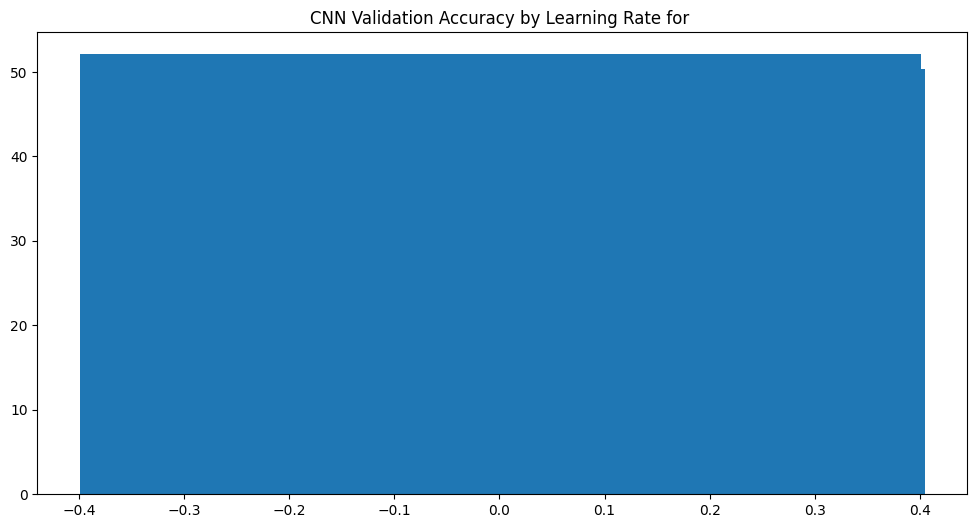

In [ ]:
cnn_hyperparams = {}
all_cnn_results = {}

for model in [SimpleCNN, DeepCNN, WideCNN]:
    best_lr, best_acc, best_epochs, cnn_results = grid_search_cnn(model_variant=model, lr_values=[0.0005, 0.001, 0.005], max_epochs=20)
    cnn_hyperparams[model.__name__] = {'lr': best_lr, 'epochs': best_epochs}
    print("Best for model:", model.__name__, "--> learning rate:", best_lr, "epochs:", best_epochs, "\n")

    all_cnn_results[model.__name__] = cnn_results

#plot_cnn_results(all_cnn_results)


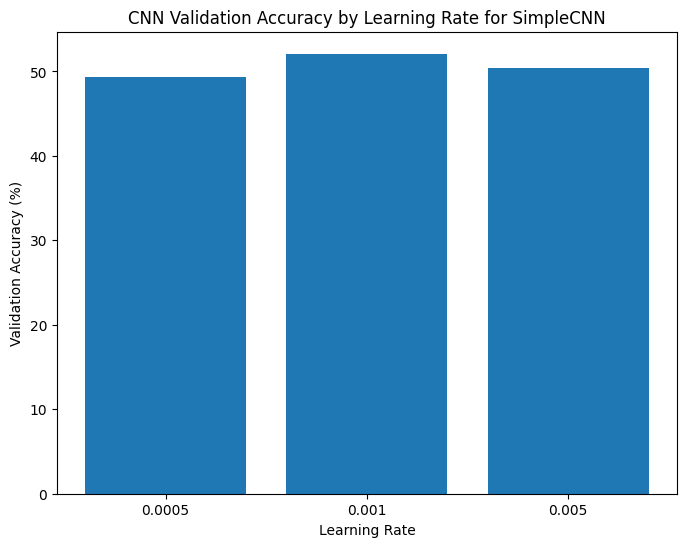

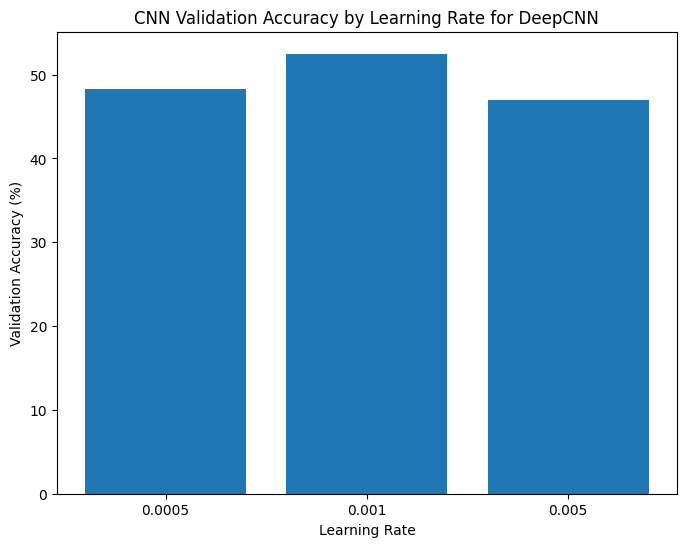

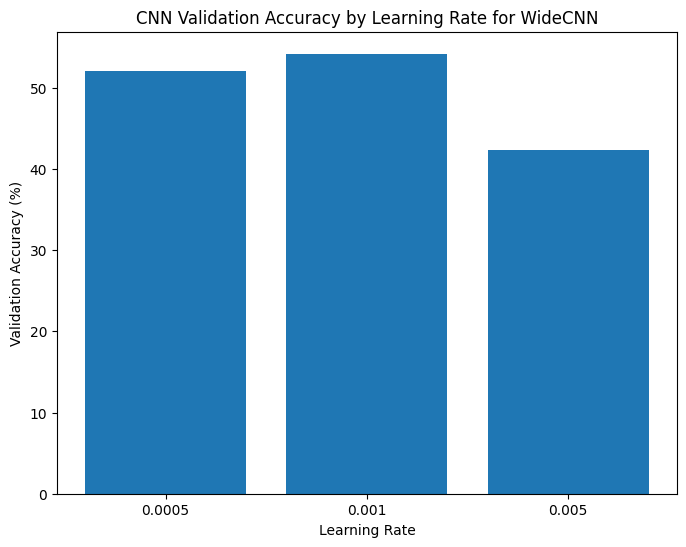

In [22]:
plot_cnn_results(all_cnn_results)

In [ ]:
pca_components_list = [50, 100, 200, 500, 1000]
svm_hyperparams = {}
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.001, 'scale']

all_svm_results = {}

for n_components in pca_components_list:
    best_C, best_gamma, best_acc, svm_results = grid_search_svm(X_train, y_train, X_val, y_val, pca_components=n_components, C_values=C_values, gamma_values=gamma_values)
    svm_hyperparams[n_components] = {'C': best_C, 'gamma': best_gamma}
    print("Best SVM params for", n_components, "PCA components:", "C:", best_C, "Gamma:", best_gamma, "\n")
    
    all_svm_results[n_components] = svm_results

#plot_svm_results(all_svm_results)

PCA components: 50 C: 0.1 Gamma: scale Validation accuracy: 26.700000000000003 % Training time (s): 2.61
PCA components: 50 C: 0.1 Gamma: 0.01 Validation accuracy: 9.6 % Training time (s): 3.003
PCA components: 50 C: 0.1 Gamma: 0.001 Validation accuracy: 26.3 % Training time (s): 2.506
PCA components: 50 C: 1 Gamma: scale Validation accuracy: 30.599999999999998 % Training time (s): 2.186
PCA components: 50 C: 1 Gamma: 0.01 Validation accuracy: 17.9 % Training time (s): 3.027
PCA components: 50 C: 1 Gamma: 0.001 Validation accuracy: 30.4 % Training time (s): 2.547
PCA components: 50 C: 10 Gamma: scale Validation accuracy: 29.799999999999997 % Training time (s): 2.66
PCA components: 50 C: 10 Gamma: 0.01 Validation accuracy: 17.1 % Training time (s): 2.874
PCA components: 50 C: 10 Gamma: 0.001 Validation accuracy: 28.9 % Training time (s): 2.891
Best SVM parameters for  50 PCA components:  C: 1 Gamma: scale with accuracy: 30.599999999999998 %
Best SVM params for 50 PCA components: C: 1 Ga

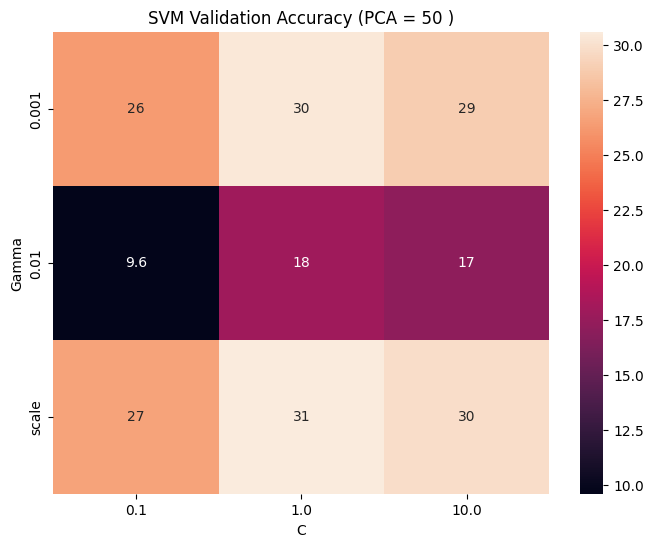

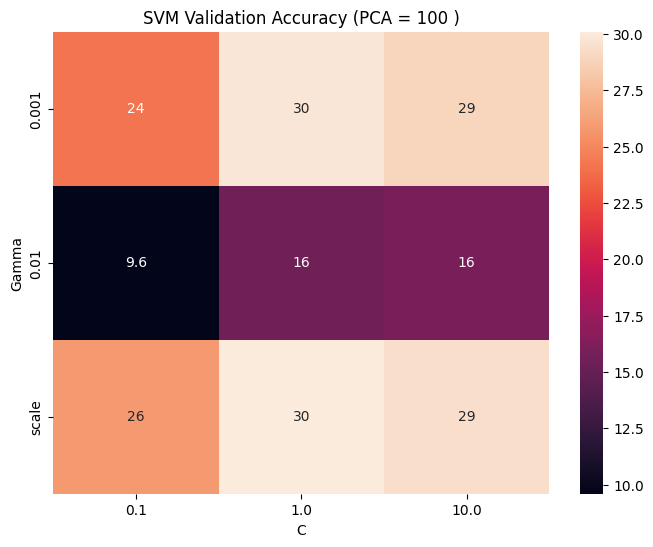

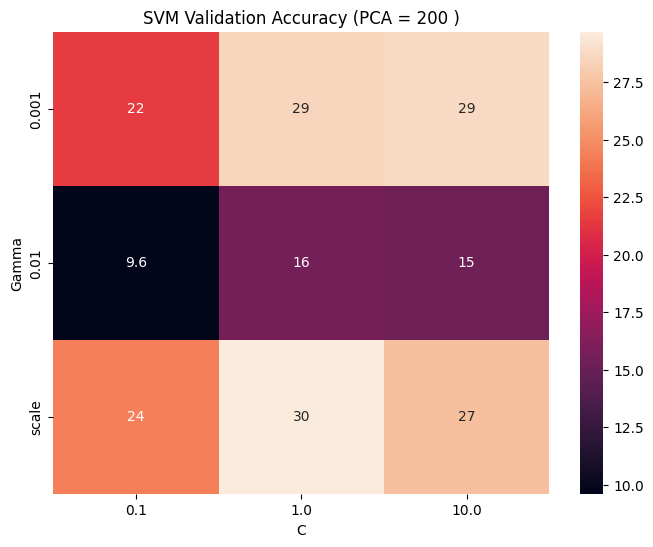

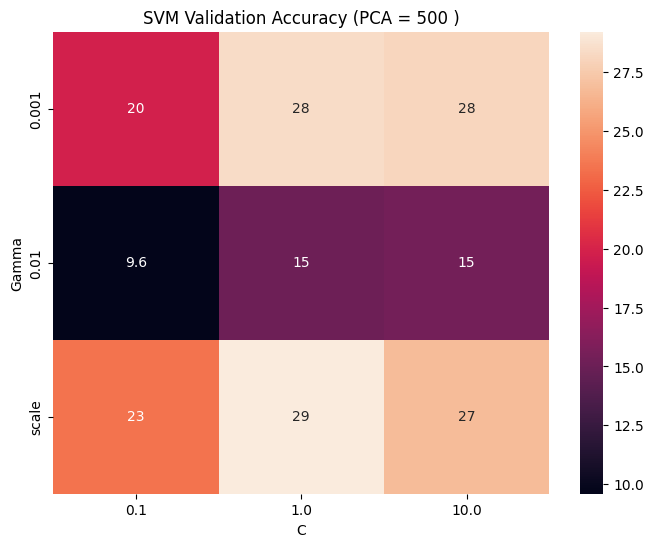

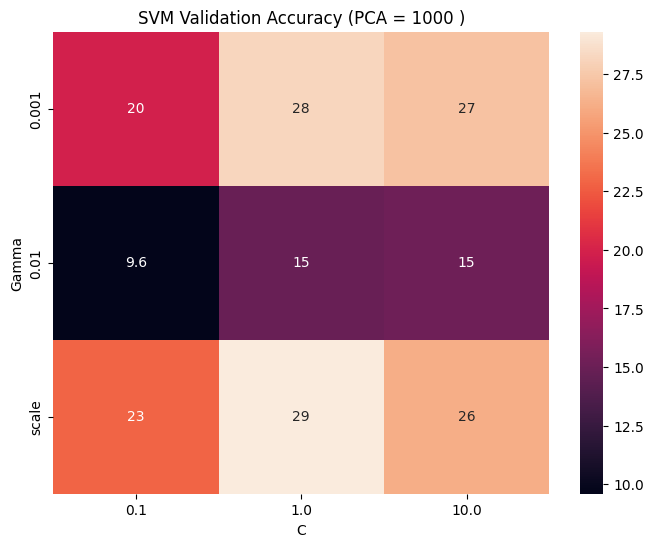

In [24]:
plot_svm_results(all_svm_results)

In [26]:
# CNN test evaluation
cnn_test_results = {}
cnn_times_dict = {}

for model in [SimpleCNN, DeepCNN, WideCNN]:
    params = cnn_hyperparams[model.__name__]
    print("Evaluating CNN model:", model.__name__)

    start_time = time.time()
    cnn_test_acc, epochs_used = validation_cnn_setup(model_variant=model, cnn_train=cnn_train, cnn_val=cnn_test, lr=params['lr'], max_epochs=params['epochs'])
    end_time = time.time()
    total_time = round(end_time - start_time, 3)

    print("Test accuracy for CNN model", model.__name__, ":", round(cnn_test_acc, 3), "% ", "Training + prediction time (s):", total_time, "\n")

    cnn_test_results[model.__name__] = cnn_test_acc
    cnn_times_dict[model.__name__] = total_time


Evaluating CNN model: SimpleCNN
Training CNN
Running loss for epoch 1 : 1.948
Running loss for epoch 2 : 1.572
Running loss for epoch 3 : 1.385
Running loss for epoch 4 : 1.225
Validation check after epoch 4 - accuracy: 51.51 %
Running loss for epoch 5 : 1.128
Running loss for epoch 6 : 1.015
Running loss for epoch 7 : 0.921
Running loss for epoch 8 : 0.83
Validation check after epoch 8 - accuracy: 54.16 %
Running loss for epoch 9 : 0.741
Running loss for epoch 10 : 0.634
Running loss for epoch 11 : 0.563
Running loss for epoch 12 : 0.443
Validation check after epoch 12 - accuracy: 54.98 %
CNN validation accuracy after  12 epochs: 54.98 % with training time  66.31
Test accuracy for CNN model SimpleCNN : 54.98 %  Training + prediction time (s): 66.315 

Evaluating CNN model: DeepCNN
Training CNN
Running loss for epoch 1 : 2.085
Running loss for epoch 2 : 1.725
Running loss for epoch 3 : 1.553
Running loss for epoch 4 : 1.449
Validation check after epoch 4 - accuracy: 43.39 %
Running los

In [27]:
# SVM test evaluation
svm_test_results = {}
svm_times_dict = {}

for n_components in pca_components_list:
    params = svm_hyperparams[n_components]
    print("Evaluating SVM with PCA component count: ", n_components)

    start_time = time.time()
    svm_test_acc = validation_pca_svm(X_train, y_train, X_test, y_test, pca_components=n_components, C=params['C'], gamma=params['gamma'])
    end_time = time.time()
    total_time = round(end_time - start_time, 3)

    print("Test accuracy for SVM with", n_components, "PCA components:", round(svm_test_acc, 3), "% Training + prediction time (s):", total_time, "\n")

    svm_test_results[n_components] = svm_test_acc
    svm_times_dict[n_components] = total_time

Evaluating SVM with PCA component count:  50
Test accuracy for SVM with 50 PCA components: 42.01 % Training + prediction time (s): 8.066 

Evaluating SVM with PCA component count:  100
Test accuracy for SVM with 100 PCA components: 43.25 % Training + prediction time (s): 8.8 

Evaluating SVM with PCA component count:  200
Test accuracy for SVM with 200 PCA components: 43.33 % Training + prediction time (s): 13.262 

Evaluating SVM with PCA component count:  500
Test accuracy for SVM with 500 PCA components: 43.08 % Training + prediction time (s): 26.004 

Evaluating SVM with PCA component count:  1000
Test accuracy for SVM with 1000 PCA components: 43.13 % Training + prediction time (s): 49.322 



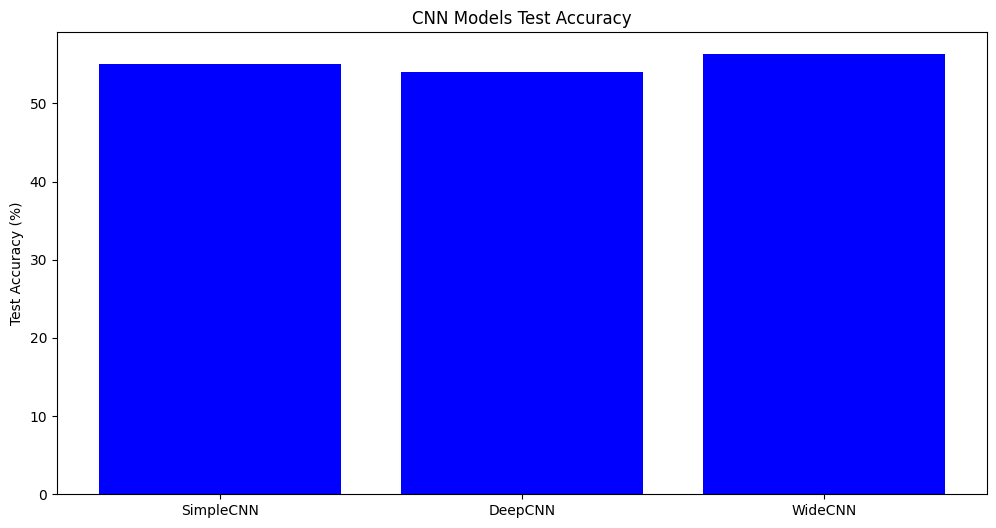

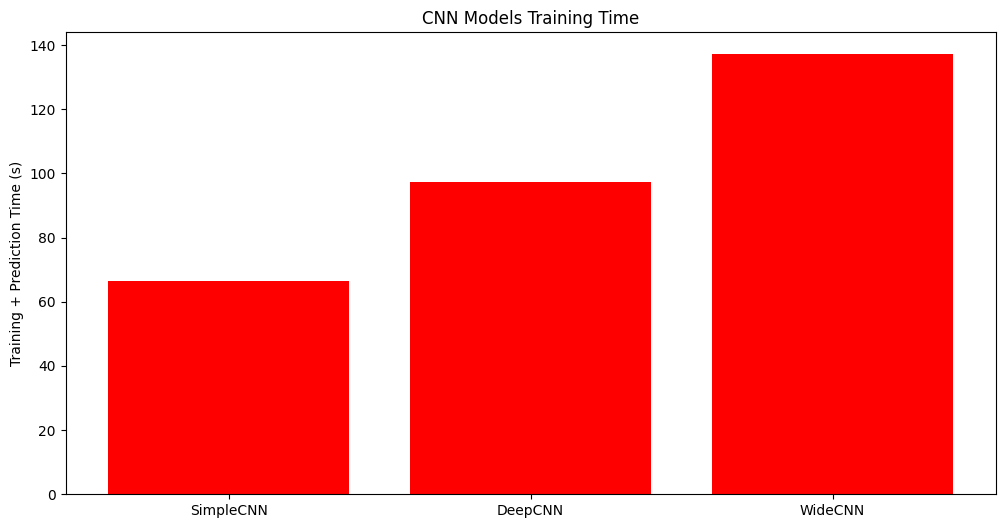

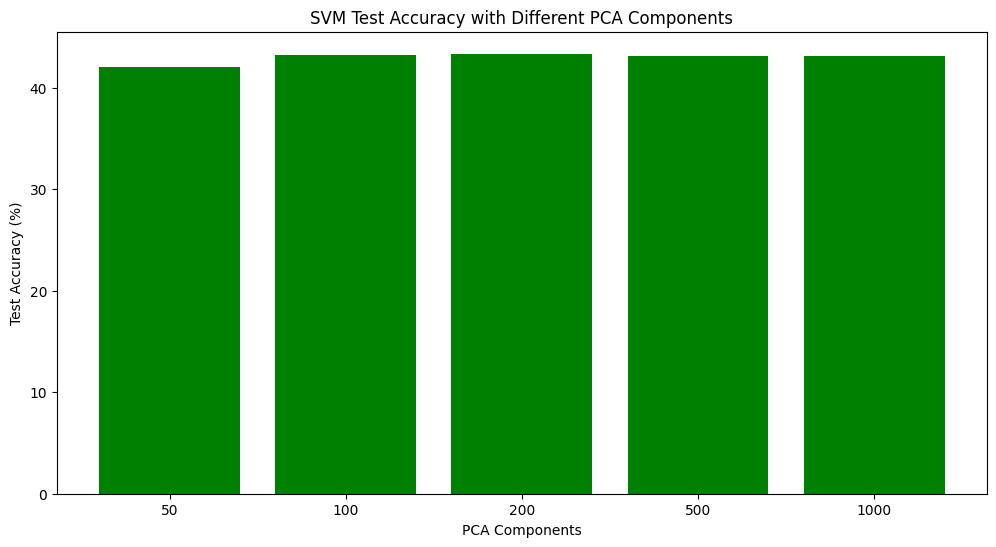

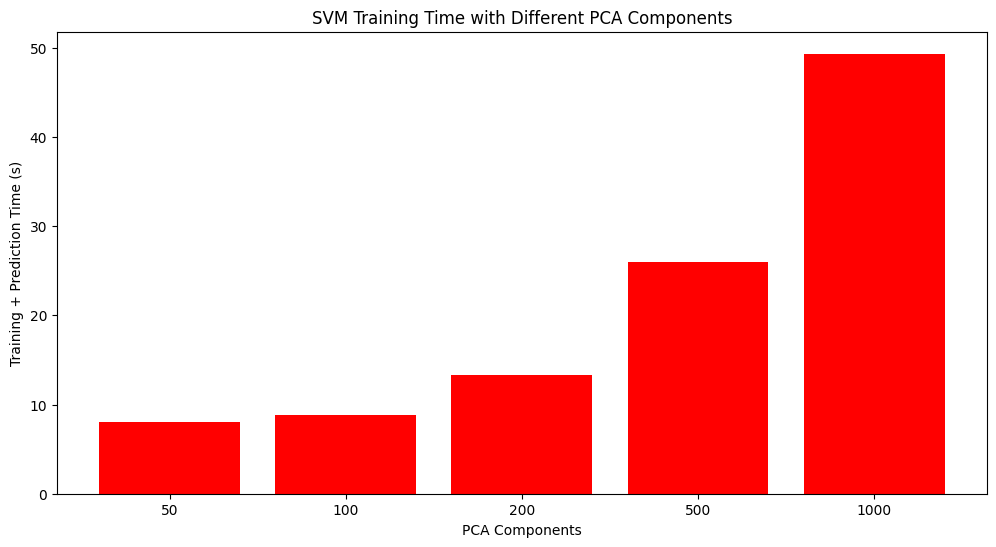

In [28]:
#cnn
cnn_models = ["SimpleCNN", "DeepCNN", "WideCNN"]
cnn_accs = [cnn_test_results[m] for m in cnn_models]
cnn_times = [cnn_times_dict[m] for m in cnn_models]

plt.figure(figsize=(12,6))
plt.bar(cnn_models, cnn_accs, color="blue")
plt.ylabel("Test Accuracy (%)")
plt.title("CNN Models Test Accuracy")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(cnn_models, cnn_times, color="red")
plt.ylabel("Training + Prediction Time (s)")
plt.title("CNN Models Training Time")
plt.show()

# svm
pca_comps = [str(c) for c in pca_components_list] 
svm_accs = [svm_test_results[c] for c in pca_components_list]
svm_times = [svm_times_dict[c] for c in pca_components_list]

plt.figure(figsize=(12,6))
plt.bar(pca_comps, svm_accs, color="green")
plt.xlabel("PCA Components")
plt.ylabel("Test Accuracy (%)")
plt.title("SVM Test Accuracy with Different PCA Components")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(pca_comps, svm_times, color="red")
plt.xlabel("PCA Components")
plt.ylabel("Training + Prediction Time (s)")
plt.title("SVM Training Time with Different PCA Components")
plt.show()


In [32]:
subset_sizes = [5000, 10000, 20000, 50000]

cnn_scaling_results = {m.__name__: [] for m in [SimpleCNN, DeepCNN, WideCNN]}
svm_scaling_results = {n: [] for n in pca_components_list}

# cnn scaling
for size in subset_sizes:
    print("CNN training with", size, "samples \n")
    cnn_subset = torch.utils.data.Subset(train_val_set_full, range(size))
    cnn_loader = torch.utils.data.DataLoader(cnn_subset, batch_size=batch_size, shuffle=True)

    for model in [SimpleCNN, DeepCNN, WideCNN]:
        params = cnn_hyperparams[model.__name__]
        start_time = time.time()
        acc, _ = validation_cnn_setup(model_variant=model, cnn_train=cnn_loader, cnn_val=cnn_test, lr=params["lr"], max_epochs=params["epochs"])
        end_time = time.time()

        cnn_scaling_results[model.__name__].append({"train_size": size, "acc": acc, "time": round(end_time - start_time, 3)
        })

        print(model.__name__, "with", size, "samples --> Accuracy:", round(acc, 3), "%  Time:", round(end_time - start_time, 3), "s")


# svm scaling
for size in subset_sizes:
    print("SVM training with", size, "samples  \n")
    
    svm_subset = torch.utils.data.Subset(train_val_set_full, range(size))
    X_sub, y_sub = dataset_to_numpy(svm_subset)

    scaler = StandardScaler()
    X_sub = scaler.fit_transform(X_sub)
    X_test_scaled = scaler.transform(X_test)

    for n_components in pca_components_list:
        params = svm_hyperparams[n_components]
        start_time = time.time()
        acc = validation_pca_svm(X_sub, y_sub, X_test, y_test, pca_components=n_components, C=params["C"], gamma=params["gamma"])
        end_time = time.time()

        svm_scaling_results[n_components].append({"train_size": size, "acc": acc, "time": round(end_time - start_time, 3)})

        print("SVM with PCA =", n_components, "and", size, "samples --> Accuracy:", round(acc, 3), "%  Time:", round(end_time - start_time, 3), "s")


CNN training with 5000 samples 

Training CNN
Running loss for epoch 1 : 1.889
Running loss for epoch 2 : 1.509
Running loss for epoch 3 : 1.329
Running loss for epoch 4 : 1.198
Validation check after epoch 4 - accuracy: 51.73 %
Running loss for epoch 5 : 1.092
Running loss for epoch 6 : 1.003
Running loss for epoch 7 : 0.895
Running loss for epoch 8 : 0.806
Validation check after epoch 8 - accuracy: 54.17 %
Running loss for epoch 9 : 0.713
Running loss for epoch 10 : 0.612
Running loss for epoch 11 : 0.524
Running loss for epoch 12 : 0.437
Validation check after epoch 12 - accuracy: 55.37 %
CNN validation accuracy after  12 epochs: 55.37 % with training time  74.937
SimpleCNN with 5000 samples --> Accuracy: 55.37 %  Time: 74.943 s
Training CNN
Running loss for epoch 1 : 2.023
Running loss for epoch 2 : 1.685
Running loss for epoch 3 : 1.519
Running loss for epoch 4 : 1.4
Validation check after epoch 4 - accuracy: 48.37 %
Running loss for epoch 5 : 1.321
Running loss for epoch 6 : 1.25

KeyboardInterrupt: 

In [ ]:
def plot_scaling_results(cnn_results, svm_results):
    plt.figure(figsize=(12,6))
    for model_name, data in cnn_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["acc"], marker="o", label=model_name)
    plt.title("CNN Accuracy vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    for model_name, data in cnn_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["time"], marker="o", label=model_name)
    plt.title("CNN Training Time vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    for n_components, data in svm_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["acc"], marker="s", label=f"PCA={n_components}")
    plt.title("SVM Accuracy vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    for n_components, data in svm_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["time"], marker="s", label=f"PCA={n_components}")
    plt.title("SVM Training Time vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()

plot_scaling_results(cnn_scaling_results, svm_scaling_results)